# Countermeasures model v1

Changes:
* Fixed convolution by creating a tested library version
* Cleared up import code, removed obsolete mask, added text cells
* Improve plotting & writeouts
* Renamed from "basic" to v1 (this is hardly a simple model)
* Use exp(-gamma) as CMReduction prior
* Use Active in place of Confirmed for exp growth
* Transform to log space (much more stable!)
* Use Half-cauchy hyperprior for DailyGrowth variance
* Use more countries (from model description doc)

## Import & initialization

In [1]:
import sys
sys.path.append("../")

In [2]:
[print(s) for s in sys.path]

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python36.zip
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/lib-dynload

/Users/benjaminsmith/.local/lib/python3.6/site-packages
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/IPython/extensions
/Users/benjaminsmith/.ipython
../


[None, None, None, None, None, None, None, None, None]

In [3]:
from epimodel import RegionDataset, read_csv, Level

In [4]:
### Initial imports
%load_ext autoreload
%autoreload 2

import datetime
import io
import logging
from pathlib import Path

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel import RegionDataset, read_csv, Level
from epimodel.pymc3_models.utils import geom_convolution, convolution
from epimodel.pymc3_models import cm_effect

In [5]:
cm_raw=pd.read_csv("../../../../data/epidemicforecasting/epimodel-covid-data/countermeasures-model-0to1-split.csv")

In [6]:
cm_raw.loc[cm_raw['General curfew - permissive']==1.0,'Code'].value_counts().sort_index()

AL       48
AT       46
BA       39
BE       44
BG       44
CN       89
CN-HK    36
DE       41
ES       53
FI       33
FR       44
GB       38
GR       45
IE       34
IQ       52
IS       40
IT       68
KR       71
KZ       44
NL       38
NP       39
PL       36
RS       43
SG       94
SI       41
SM       47
VA       51
ZA       35
Name: Code, dtype: int64

In [7]:
cm_raw.loc[cm_raw['General curfew - strict']==1.0,'Code'].value_counts().sort_index()

AL    48
AT    46
BA    39
BE    44
BG    44
CN    89
DE    41
ES    47
FI    33
FR    44
GB    38
GR    38
IE    34
IS    40
IT    54
NL    38
NP    37
PL    36
RS    43
SI    41
SM    47
VA    51
ZA    35
Name: Code, dtype: int64

In [8]:
curfew_compare = pd.DataFrame(cm_raw.loc[cm_raw['General curfew - permissive']==1.0,'Code'].value_counts().sort_index()).merge(
    pd.DataFrame(cm_raw.loc[cm_raw['General curfew - strict']==1.0,'Code'].value_counts().sort_index()),
    left_index=True,right_index=True,how='outer'
)

In [9]:
curfew_compare['diff']=curfew_compare.Code_x-curfew_compare.Code_y

In [10]:
curfew_compare['diff']

AL        0.0
AT        0.0
BA        0.0
BE        0.0
BG        0.0
CN        0.0
CN-HK     NaN
DE        0.0
ES        6.0
FI        0.0
FR        0.0
GB        0.0
GR        7.0
IE        0.0
IQ        NaN
IS        0.0
IT       14.0
KR        NaN
KZ        NaN
NL        0.0
NP        2.0
PL        0.0
RS        0.0
SG        NaN
SI        0.0
SM        0.0
VA        0.0
ZA        0.0
Name: diff, dtype: float64

In [74]:
cm_simp=cm_raw.copy()
cm_simp['General curfew - any'] = 0.0
cm_simp.loc[(cm_raw['General curfew - permissive'] + cm_raw['General curfew - strict'])>0,'General curfew - any']=1.0
cm_simp=cm_simp.drop(['General curfew - permissive','General curfew - strict'],axis=1)

In [76]:
cm_simp.to_csv("../../../../data/epidemicforecasting/epimodel-covid-data/countermeasures-model-0to1-split_simp.csv")

## Loading data and parameter settings

In [11]:
#Cs = ['ES', 'DE', 'CH', 'FR', 'BE', 'AT', 'HU', 'GE', 'CZ', 'GR', 'SK', 'HR', 'FI', 'GB', 'DK', 'NO', 'PL', 'SI', 'IS', 'NL', 'PT', 'SE']
# European selection from model doc
Cs = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
# Same, outside Europe
Cs += ['AD', 'CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'SG']
nCs = len(Cs)

CMs = ['Masks over 60',
 'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
# 'General curfew - permissive',
# 'General curfew - strict',
 'Healthcare specialisation over 0.2',
       'General curfew - any'
      ]
nCMs = len(CMs)

CMDelayCut = 10
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])

data = cm_effect.Loader('2020-02-15', '2020-04-15', Cs, CMs, active_cm_file='countermeasures-model-0to1-split_simp.csv',
                       data_dir=Path("../../../../data/epidemicforecasting/epimodel-covid-data/"))
data.print_stats()
Ds = data.Ds
nDs = len(data.Ds)

ActiveCMs = data.get_ActiveCMs(pd.date_range(
    start=data.Ds[0]-pd.DateOffset(days=CMDelayCut), end=data.Ds[-1], tz="utc"))
Confirmed = data.Confirmed
Active = data.Active

def statstr(d):
    return f"{d.mean():.3g} ({np.quantile(d, 0.05):.3g} .. {np.quantile(d, 0.95):.3g})"

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']



Countermeasures                            min   .. mean  .. max
 0 Masks over 60                              0.000 .. 0.016 .. 1.000  {0.0, 1.0}
 1 Asymptomatic contact isolation             0.000 .. 0.071 .. 1.000  {0.0, 1.0}
 2 Gatherings limited to 10                   0.000 .. 0.090 .. 1.000  {0.0, 1.0}
 3 Gatherings limited to 100                  0.000 .. 0.162 .. 1.000  {0.0, 1.0}
 4 Gatherings limited to 1000                 0.000 .. 0.189 .. 1.000  {0.0, 1.0}
 5 Business suspended - some                  0.000 .. 0.198 .. 1.000  {0.0, 1.0}
 6 Business suspended - many                  0.000 .. 0.124 .. 1.000  {0.0, 1.0}
 7 Schools and universities closed            0.000 .. 0.287 .. 1.000  {0.0, 1.0}
 8 Healthcare specialisation over 0.2         0.000 .. 0.033 .. 1.000  {0.0, 1.0}
 9 General curfew - any                       0.000 .. 0.132 .. 1.000  {0.0, 1.0}


In [12]:
data

## Model definition

In [13]:
## !!! (almost) All variables below are in Log-space !!!!

with pm.Model() as model:
    # [] Baseline growth rate (wide prior OK, mean estimates ~10% daily growth)
    #BaseGrowthRate = pm.Normal("BaseGrowthRate", np.log(1.2), 2.0)
    
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Normal("InitialSize", 0.0, 10, shape=(nCs,))
    
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Normal("CountryGrowthRate", np.log(1.2), 0.3, shape=(nCs,))
    
    # [CM] How much countermeasures reduce growth rate
    # TODO: Possibly use another distribution
    CMReductionGamma = pm.Gamma("CMReductionGamma", 0.5, 1.0, shape=(nCMs,))
    CMReduction = pm.Deterministic("CMReduction", T.exp((-1.0) * CMReductionGamma))

    # [country, CM, day + CMDelayCut] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReductionGamma, (1, nCMs, 1)) * ActiveCMs
    
    # [country, day + CMDelayCut] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.sum(ActiveCMReduction, axis=1))

    # [country, day + CMDelayCut] Convolution of GrowthReduction by DelayProb along days
    DelayedGrowthReduction = convolution(GrowthReduction, DelayProb, axis=1)

    # Erase early DlayedGrowthRates in first ~10 days (would assume them non-present otherwise!)
    DelayedGrowthReduction = DelayedGrowthReduction[:, CMDelayCut:]
    
    # [country, day] The ideal predicted daily growth
    PredictedGrowth = pm.Deterministic("PredictedGrowth",
        T.reshape(CountryGrowthRate, (nCs, 1)) - DelayedGrowthReduction)
    
    # [country, day] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Normal("DailyGrowth", PredictedGrowth, 0.1, shape=(nCs, nDs))

    # Below I assume plain exponentia growth of Active rather than e.g. depending on the remaining
    # susceptible opulation etc.

    # [country, day] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) + DailyGrowth.cumsum(axis=1))

    # [country, day] Cummulative tested positives
    Observed = pm.Normal("Observed", Size, 0.4, shape=(nCs, nDs), observed=np.log(Active))

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


## Run MCMC inference

1000 steps is enough for seeing the convergence and rough results, more is better, though.

In [15]:
print(model.check_test_point())
with model:
    trace = pm.sample(1000, chains=4, cores=4, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


InitialSize                  -115.97
CountryGrowthRate              10.26
CMReductionGamma_log__        -14.19
DailyGrowth                  3038.49
Observed_missing                0.00
Observed                 -7987007.87
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Observed_missing, DailyGrowth, CMReductionGamma, CountryGrowthRate, InitialSize]
INFO:pymc3:NUTS: [Observed_missing, DailyGrowth, CMReductionGamma, CountryGrowthRate, InitialSize]
Sampling 4 chains, 1 divergences: 100%|██████████| 6000/6000 [09:40<00:00, 10.34draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


## Plot chain stability

In [16]:
pm.gelman_rubin(trace)

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/pymc3/stats/__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


<xarray.Dataset>
Dimensions:                  (CMReductionGamma_dim_0: 10, CMReduction_dim_0: 10, CountryGrowthRate_dim_0: 36, DailyGrowth_dim_0: 36, DailyGrowth_dim_1: 61, GrowthReduction_dim_0: 36, GrowthReduction_dim_1: 71, InitialSize_dim_0: 36, Observed_missing_dim_0: 614, PredictedGrowth_dim_0: 36, PredictedGrowth_dim_1: 61, Size_dim_0: 36, Size_dim_1: 61)
Coordinates:
  * InitialSize_dim_0        (InitialSize_dim_0) int64 0 1 2 3 4 ... 32 33 34 35
  * CountryGrowthRate_dim_0  (CountryGrowthRate_dim_0) int64 0 1 2 ... 33 34 35
  * DailyGrowth_dim_0        (DailyGrowth_dim_0) int64 0 1 2 3 4 ... 32 33 34 35
  * DailyGrowth_dim_1        (DailyGrowth_dim_1) int64 0 1 2 3 4 ... 57 58 59 60
  * Observed_missing_dim_0   (Observed_missing_dim_0) int64 0 1 2 ... 612 613
  * CMReductionGamma_dim_0   (CMReductionGamma_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * CMReduction_dim_0        (CMReduction_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * GrowthReduction_dim_0    (GrowthReduction_dim_0) int64 0 1 2 3 ... 33 34 35
  * GrowthReduction_dim_1    (GrowthReduction_dim_1) int64 0 1 2 3 ... 68 69 70
  * PredictedGrowth_dim_0    (PredictedGrowth_dim_0) int64 0 1 2 3 ... 33 34 35
  * PredictedGrowth_dim_1    (PredictedGrowth_dim_1) int64 0 1 2 3 ... 58 59 60
  * Size_dim_0               (Size_dim_0) int64 0 1 2 3 4 5 ... 31 32 33 34 35
  * Size_dim_1               (Size_dim_1) int64 0 1 2 3 4 5 ... 56 57 58 59 60
Data variables:
    InitialSize              (InitialSize_dim_0) float64 1.002 1.004 ... 1.001
    CountryGrowthRate        (CountryGrowthRate_dim_0) float64 1.002 ... 1.016
    DailyGrowth              (DailyGrowth_dim_0, DailyGrowth_dim_1) float64 1.003 ... 0.9998
    Observed_missing         (Observed_missing_dim_0) float64 1.002 ... 1.002
    CMReductionGamma         (CMReductionGamma_dim_0) float64 1.001 ... 1.002
    CMReduction              (CMReduction_dim_0) float64 1.001 1.019 ... 1.002
    GrowthReduction          (GrowthReduction_dim_0, GrowthReduction_dim_1) float64 nan ... 1.02
    PredictedGrowth          (PredictedGrowth_dim_0, PredictedGrowth_dim_1) float64 1.002 ... 1.001
    Size                     (Size_dim_0, Size_dim_1) float64 1.002 ... 1.001

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminsmith/anaconda/envs/pymc3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

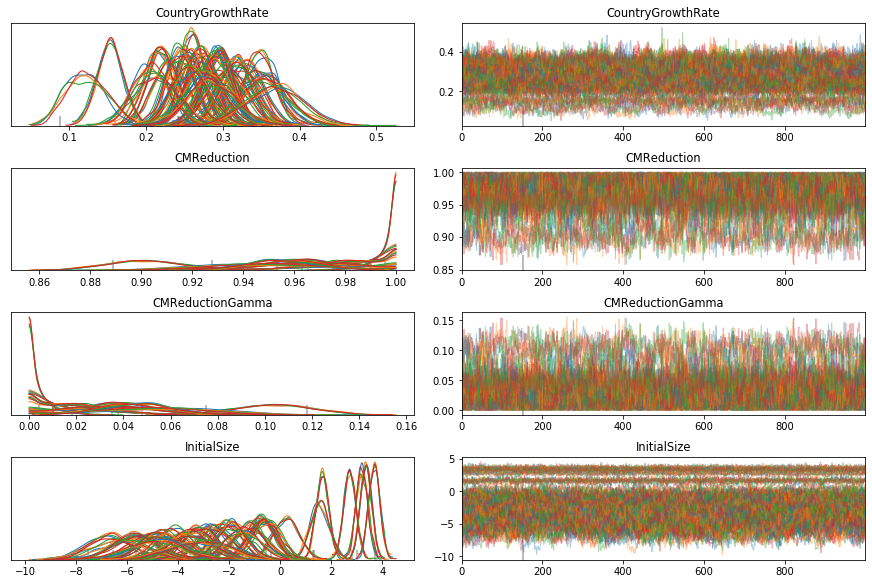

In [17]:
_ = pm.traceplot(trace, var_names=["CountryGrowthRate", "CMReduction", "CMReductionGamma", "InitialSize"])

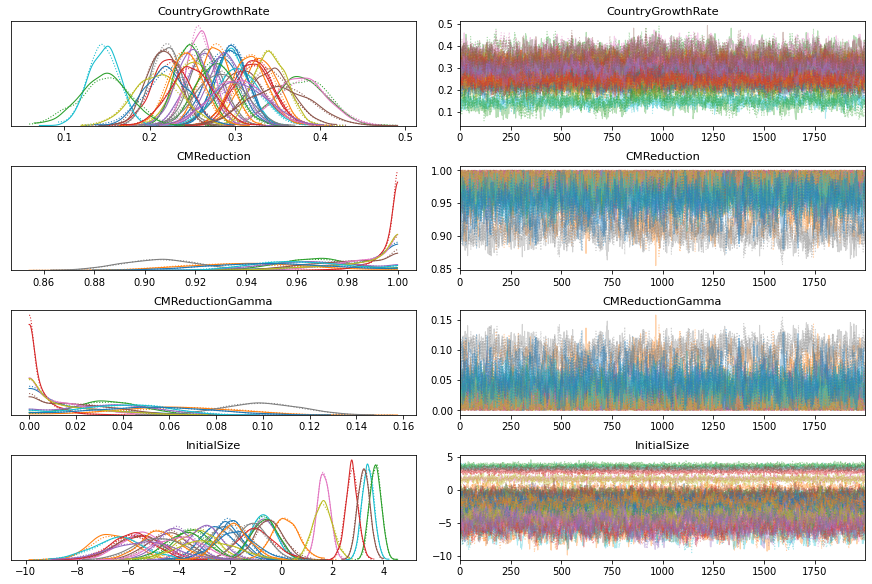

In [63]:
_ = pm.traceplot(trace, var_names=["CountryGrowthRate", "CMReduction", "CMReductionGamma", "InitialSize"])

## Plot inferred countermeasure effect

Effects are multiplicative (e.g. for a countermeasure that is a strenghtening of another, the inferred strenght is the additional multiplier).

The countermeasure strength is the multiplicative effect at feature=1.0.

 0 Masks over 60                            CMReduction 0.983 (0.944 .. 1)
 1 Asymptomatic contact isolation           CMReduction 0.963 (0.924 .. 0.998)
 2 Gatherings limited to 10                 CMReduction 0.962 (0.94 .. 0.986)
 3 Gatherings limited to 100                CMReduction 0.996 (0.984 .. 1)
 4 Gatherings limited to 1000               CMReduction 0.967 (0.937 .. 0.996)
 5 Business suspended - some                CMReduction 0.982 (0.955 .. 1)
 6 Business suspended - many                CMReduction 0.981 (0.956 .. 1)
 7 Schools and universities closed          CMReduction 0.902 (0.877 .. 0.927)
 8 Healthcare specialisation over 0.2       CMReduction 0.947 (0.909 .. 0.99)
 9 General curfew - any                     CMReduction 0.956 (0.933 .. 0.981)


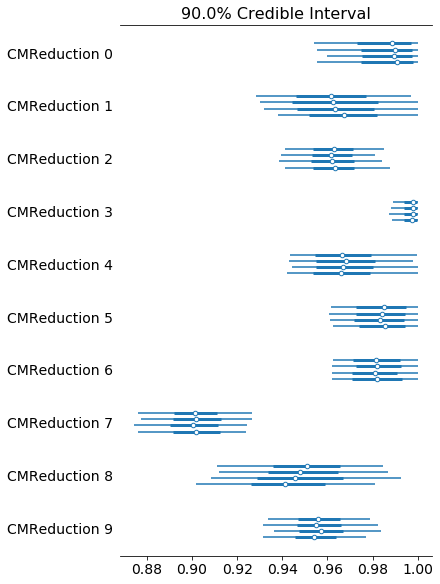

In [18]:
pm.forestplot(trace, var_names=['CMReduction'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction {statstr(trace['CMReduction'][:,i])}")

Cummulated CM effects
 0 Masks over 60                            CMReduction 0.983 (0.944 .. 1)
 1 Asymptomatic contact isolation           CMReduction 0.963 (0.924 .. 0.998)
 2 Gatherings limited to 10                 CMReduction 0.926 (0.897 .. 0.955)
 3 Gatherings limited to 100                CMReduction 0.963 (0.933 .. 0.992)
 4 Gatherings limited to 1000               CMReduction 0.967 (0.937 .. 0.996)
 5 Business suspended - some                CMReduction 0.982 (0.955 .. 1)
 6 Business suspended - many                CMReduction 0.963 (0.938 .. 0.987)
 7 Schools and universities closed          CMReduction 0.902 (0.877 .. 0.927)
 8 Healthcare specialisation over 0.2       CMReduction 0.947 (0.909 .. 0.99)
 9 General curfew - any                     CMReduction 0.906 (0.86 .. 0.954)


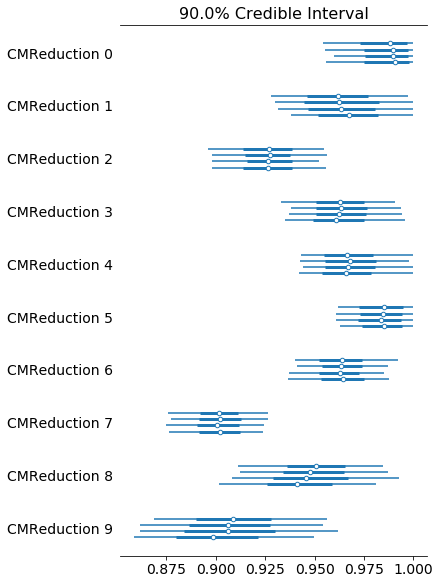

In [19]:
print("Cummulated CM effects")

a = trace['CMReduction']
a[:, 3] *= a[:, 4]
a[:, 2] *= a[:, 3]
a[:, 6] *= a[:, 5]
a[:, 9] *= a[:, 8]
from copy import deepcopy
trace2 = deepcopy(trace)
trace2.add_values({'CMReduction': a}, True)

pm.forestplot(trace2, var_names=['CMReduction'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction {statstr(trace2['CMReduction'][:,i])}")

In [39]:
import plotly
from plotly import graph_objects as go
import plotly.express as px
import datetime

def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
def plot_traces(data, name):
    fig = go.FigureWidget()
    fig.layout.title = go.layout.Title(text=name)
    for i, c in enumerate(Cs):
        d = data[:,i,:]
        color = (px.colors.qualitative.Dark24 * 10)[i]
        plot_line_CIs(fig, Ds, d, c, color)
    datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    fname = f'plot_{datestr}_{name}.html'
    plotly.io.write_html(fig, fname, include_plotlyjs='cdn')
    print(f"Wrote {fname}")
    return fig

ModuleNotFoundError: No module named 'plotly'

In [40]:
plot_traces(np.exp(trace['DailyGrowth']), 'active_growth')

NameError: name 'plot_traces' is not defined

In [69]:
plot_traces(np.exp(trace['Size']), 'active_confirmed')

Wrote plot_2020-04-16_04-03-22_active_confirmed.html


FigureWidget({
    'data': [{'legendgroup': 'AT',
              'line': {'color': '#2E91E5'},
              'n…